In [25]:
import numpy as np
import yaml
import sys
from matplotlib import pyplot as plt, patches

# Import modules from path
sys.path.append('../modules/')
import postprocesstools as pptools

plt.rcParams.update({'font.size': 10, 'axes.titlesize': 'medium'})

In [ ]:
transectNames = ['WOCE AR7W', 'Denmark Strait', 'Iceland-Faroe-Scotland', 'OSNAP section East', 'OSNAP section West']

In [53]:
def get_variable(da, layerThickness):
    """
    """
    
    kmax = layerThickness.shape[-1]
    variable = (da[0, :, :kmax] * layerThickness).sum(dim='nVertLevels')
    variable = variable / layerThickness.sum(dim='nVertLevels')
    
    return variable

In [58]:
def plot_regions(datestring, clims, bbox, depth=500, decade='1947-1957'):
    """
    """

    # Make figure
    fig, axs = plt.subplots(2, 3, figsize=(12, 6), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
    prefix, cmaps = 'timeMonthly_avg_', ['inferno', 'viridis', 'Blues']
    varnames = ['temperature', 'salinity', 'potentialDensity']
    labels = ['temperature [$^{\\circ}$C]', 'salinity [PSU]', '$\\sigma_{\\theta}$ [kg m$^3$]']

    # Loop through meshes
    for row, meshName in zip(axs, ['LR', 'HR']):

        # Load paths dict from yaml
        with open(f'../yaml/paths_{meshName}.yaml', 'r') as f:
            paths = yaml.safe_load(f)

        # Load mesh variables
        mesh = xr.open_dataset(paths['meshfile'])
        lonCell = np.rad2deg(mesh.lonCell.values) - 360
        latCell = np.rad2deg(mesh.latCell.values)
        depths = mesh.refBottomDepth.values
        
        # Load remap variables
        meshLongName = paths['meshfile'].split('/')[-2]
        remapvars = pptools.build_remapper(meshLongName, bbox=bbox)

        # Load results
        f = paths['results'][decade] + '/' + paths['prefix'] + '.' + datestring + '.nc'
        results = xr.open_dataset(f)
        
        # Thickness
        kmax = abs(depths - depth).argmin() + 1
        layerThickness = results[prefix + 'layerThickness'][0, :, :kmax]
        
        # Get velocity
        u = get_variable(results[prefix + 'velocityZonal'], layerThickness)
        v = get_variable(results[prefix + 'velocityMeridional'], layerThickness)

        # Loop through variables
        for ax, varname, clim, cmap, label in zip(row, varnames, clims, cmaps, labels):

            # Get variable at transect points
            prefix2 = 'activeTracers_' if varname in ['temperature', 'salinity'] else ''
            variable = get_variable(results[prefix + prefix2 + varname], layerThickness)
            if varname == 'potentialDensity':
                variable = variable - 1000
            
            variable = pptools.remap(variable, **remapvars)

            # Plot variable
            c = ax.pcolormesh(variable.lon, variable.lat, variable, cmap=cmap, vmin=clim[0], vmax=clim[1])
            
            # Plot velocity vectors
            velocity = []
            for direction in ['Zonal', 'Meridional']:
                variable = results[prefix + 'velocity' + direction][0, :, 0]
                variable = pptools.remap(variable, **remapvars)
                velocity.append(variable)
            u, v = velocity
            q = ax.quiver(u.lon, u.lat, u, v)

            # Formatting
            ax.add_patch(patches.Rectangle([0, 0], 1, 1, fc='gray', transform=ax.transAxes, zorder=-10))
            ax.set_xlim(bbox[:2])
            ax.set_ylim(bbox[2:])
            
            if meshName == 'HR':
                pos = ax.get_position()
                cax = fig.add_axes([pos.x0, 0.03, pos.width, 0.02])
                fig.colorbar(c, cax=cax, orientation='horizontal', label=label)
            else:
                ax.xaxis.set_ticks([])
            if varname != 'temperature':
                ax.yaxis.set_ticks([])
    
    return fig, axs

In [56]:
def plot_transects(datestring, transectName, clims, bbox, decade='1947-1957'):
    """
    """

    # Make figure
    fig, axs = plt.subplots(2, 3, figsize=(12, 6), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
    prefix, cmaps, floors = 'timeMonthly_avg_', ['inferno', 'viridis', 'Blues'], [-10, 20, 0]
    varnames = ['temperature', 'salinity', 'potentialDensity']
    labels = ['temperature [$^{\\circ}$C]', 'salinity [PSU]', '$\\sigma_{\\theta}$ [kg m$^3$]']

    # Loop through meshes
    for row, meshName in zip(axs, ['LR', 'HR']):

        # Load paths dict from yaml
        with open(f'../yaml/paths_{meshName}.yaml', 'r') as f:
            paths = yaml.safe_load(f)

        # Load mesh variables
        mesh = xr.open_dataset(paths['meshfile'])
        lonCell = np.rad2deg(mesh.lonCell.values) - 360
        depth = mesh.refBottomDepth.values

        # Load transects
        transects = xr.open_dataset(paths['transectfile'])
        transects['transectNames'] = transects.transectNames.astype(str)

        # Load results
        f = paths['results'][decade] + '/' + paths['prefix'] + '.' + datestring + '.nc'
        results = xr.open_dataset(f)

        # Get transect indexes
        iTransect = transects.transectNames == transectName
        cellMask = transects.transectCellMasks[:, iTransect]
        cellMask, = np.where(cellMask.values.flatten())
        cellMask = cellMask[lonCell[cellMask].argsort()]
        lonCellTransect = lonCell[cellMask]

        # Loop through variables
        for ax, varname, clim, cmap, floor, label in zip(row, varnames, clims, cmaps, floors, labels):

            # Set colormap
            cmap_obj = plt.get_cmap(cmap)
            cmap_obj.set_bad(color='gray')

            # Get variable at transect points
            prefix2 = 'activeTracers_' if varname in ['temperature', 'salinity'] else ''
            variable = results[prefix + prefix2 + varname][0, cellMask, :].values.T
            if varname == 'potentialDensity':
                variable = variable - 1000
            variable = np.ma.masked_where(variable<floor, variable)

            # Plot variable
            c = ax.pcolormesh(lonCellTransect, depth, variable, cmap=cmap_obj, vmin=clim[0], vmax=clim[1])
            
            # Plot velocity
            variable = results[prefix + 'velocityMeridional'][0, cellMask, :].values.T
            ax.contour(lonCellTransect, depth, variable, colors='w', linewidths=0.5)

            # Formatting
            ax.set_xlim(bbox[:2])
            ax.set_ylim(bbox[2:])
            
            if meshName == 'HR':
                pos = ax.get_position()
                cax = fig.add_axes([pos.x0, 0.03, pos.width, 0.02])
                fig.colorbar(c, cax=cax, orientation='horizontal', label=label)
            else:
                ax.xaxis.set_ticks([])
            if varname != 'temperature':
                ax.yaxis.set_ticks([])
    
    return fig, axs

***

### OSNAP

In [4]:
transectName, clims, bbox = 'OSNAP section East', [(2, 10), (34.5, 35.1), (27.5, 27.9)], [-43, -8, 4000, 0]

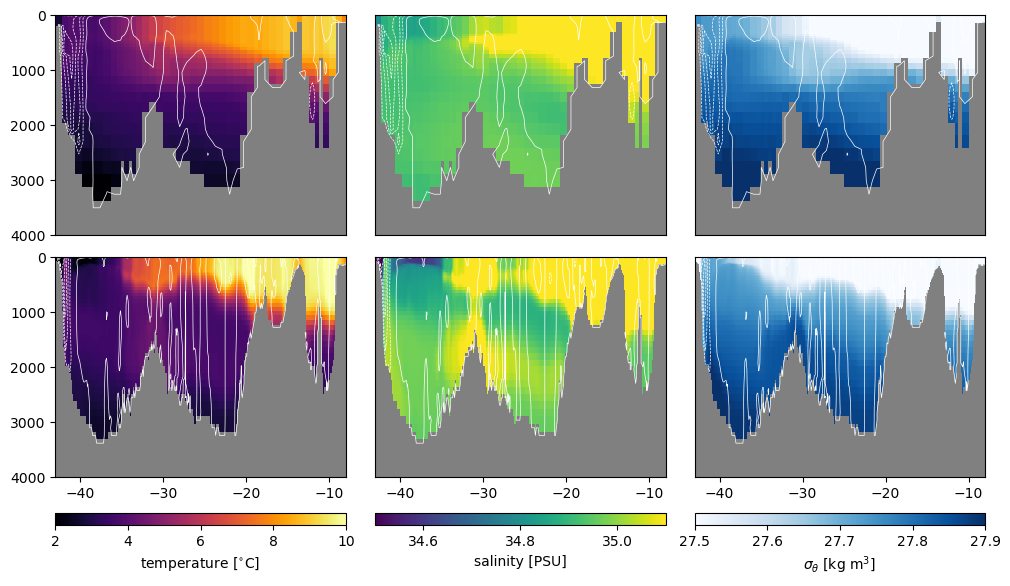

In [9]:
# January year 1
fig, axs = plot_transects('0001-01-01', transectName, clims, bbox)

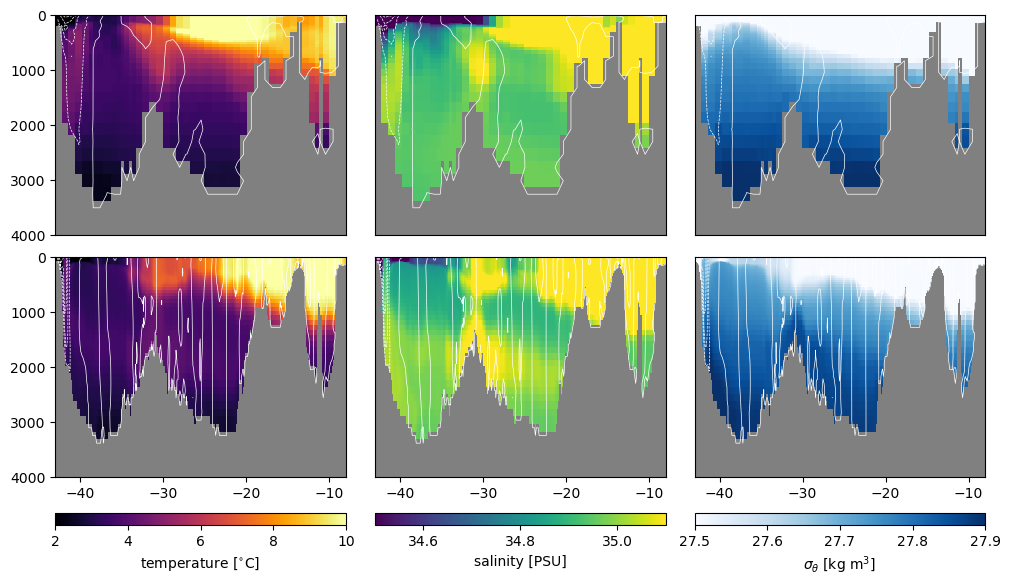

In [196]:
# January year 3
fig, axs = plot_transects('0003-01-01', transectName, clims, bbox)

***

### Denmark Strait 

In [197]:
transectName, clims, bbox = 'Denmark Strait', [(-2, 8), (33, 35.3), (27.5, 28)], [-32.1, -23.8, 800, 0]

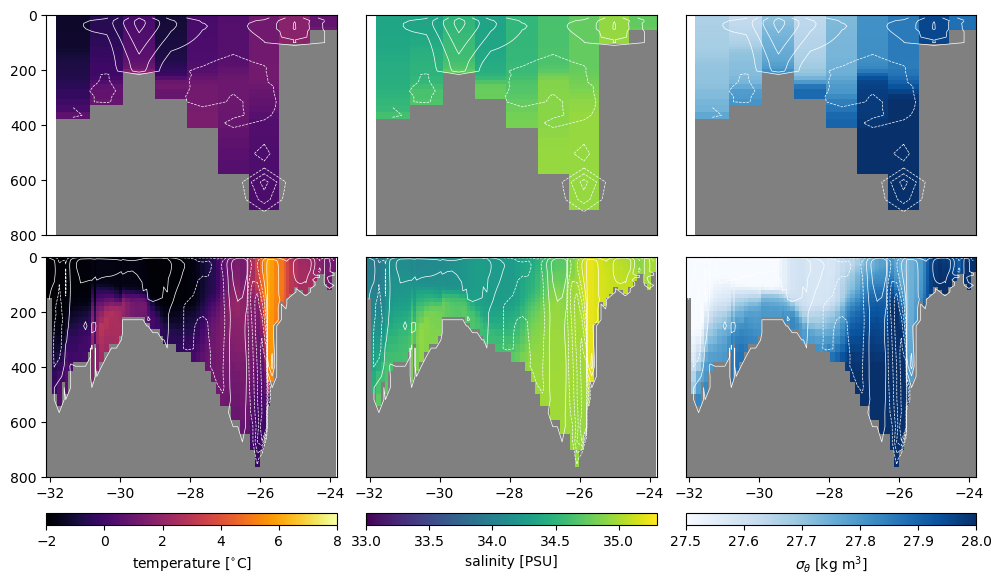

In [198]:
# January year 1
fig, axs = plot_transects('0001-01-01', transectName, clims, bbox)

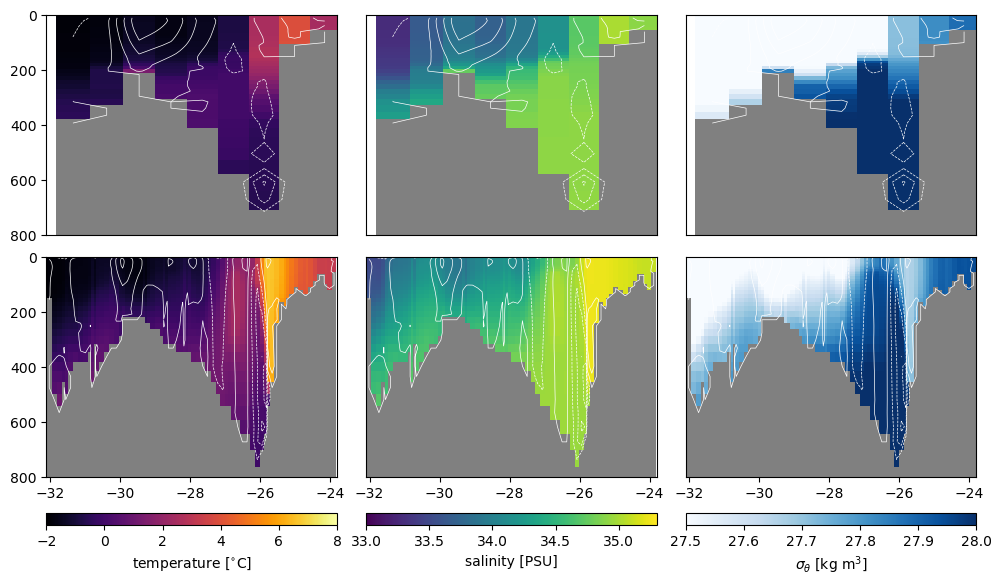

In [199]:
# January year 3
fig, axs = plot_transects('0003-01-01', transectName, clims, bbox)

***

### Western SPG

In [62]:
# WSPG
clims, bbox = [(-2, 8), (32, 35.5), (27, 28)], [-65, -20, 57, 70]

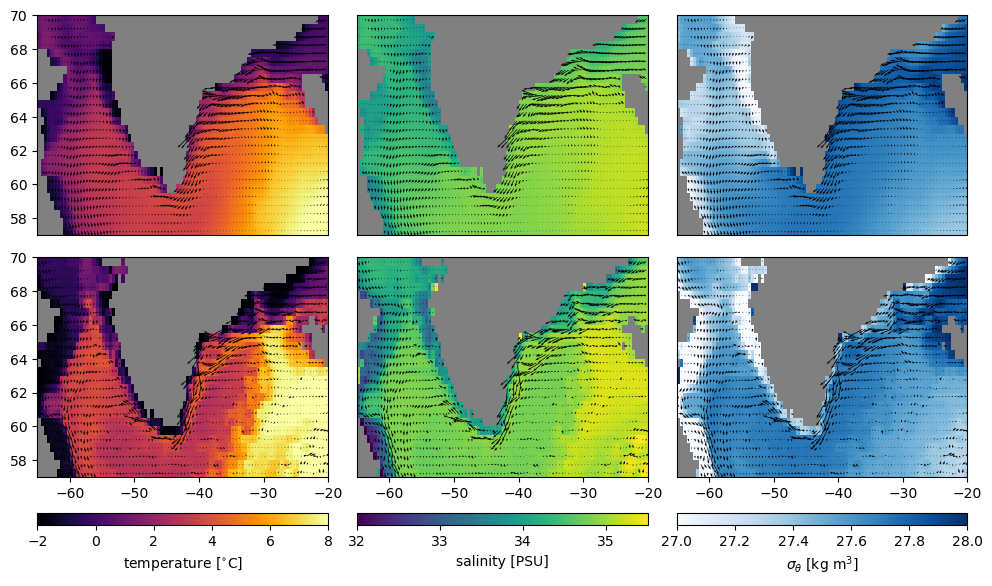

In [63]:
# Janunary year 1
fig, axs = plot_regions('0001-01-01', clims, bbox)

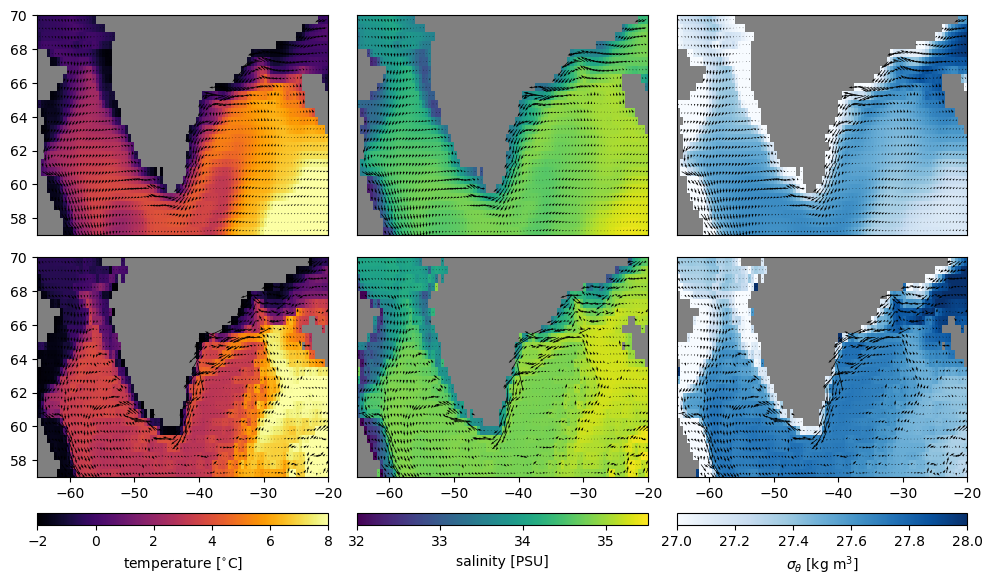

In [64]:
# January year 3
fig, axs = plot_regions('0003-01-01', clims, bbox)

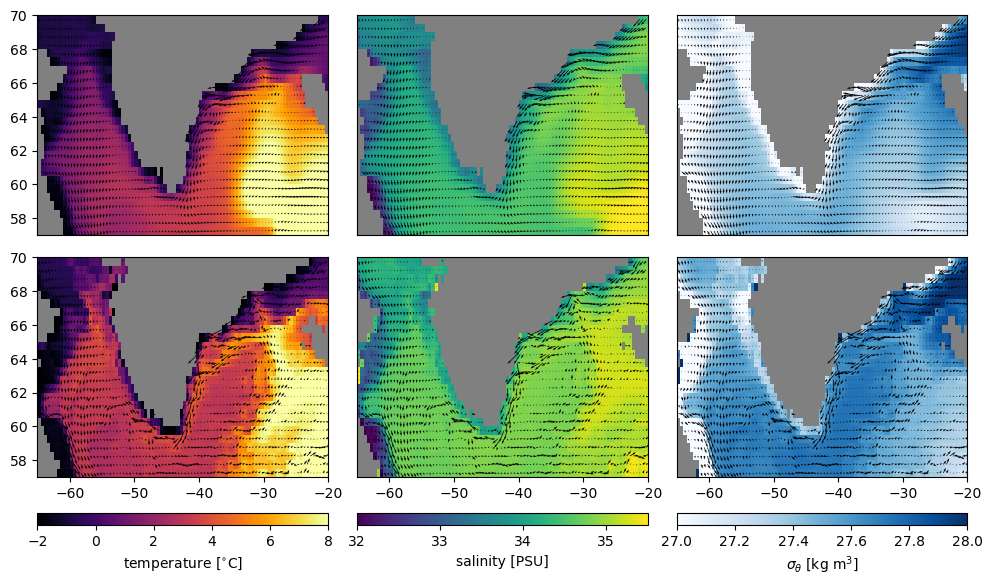

In [65]:
# January year 10
fig, axs = plot_regions('0010-01-01', clims, bbox)

***

### Budgets

Tracer budget

$$\frac{\partial C}{\partial t} = \underbrace{\int_{top}\Phi_Cds_{top}}_{\text{surface flux}} - \underbrace{\int_{side}u_\hat{n}\frac{\partial C}{\partial\hat{n}}ds_{side}}_{\text{edge advection}} - \underbrace{\int_{bottom}w\frac{\partial C}{\partial z}\bigg|_{z0}ds_{bottom}}_{\text{bottom advection}} + \int_A\left[-\underbrace{\left(\mathbf{u}_h\cdot\nabla_h C + w\frac{\partial C}{\partial z}\right)}_{\text{interior advection}} + \underbrace{\nabla_h\cdot\kappa_h\nabla_hC + \frac{\partial}{\partial z}\left(\kappa_v\frac{\partial C}{\partial z}\right)}_{\text{interior mixing}}\right]dA$$